In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.utils.data import Dataset

import pandas as pd
import matplotlib.pyplot as plt
import gcsfs
import numpy as np
import xarray as xr

In [2]:
gen = np.random.default_rng(340150)

In [79]:
210 / 262

0.8015267175572519

In [83]:
13 / 262
39 / 262

0.14885496183206107

In [3]:
perm = gen.permutation(262)
ens = np.array(perm)
ens[np.where(perm >= 175)] = ens[np.where(perm >= 175)] + 1

train_indx = perm[0:210]
val_indx = perm[210:223]
test_indx = perm[223: ]

train_ens = ens[0:210]
val_ens = ens[210:223]
test_ens = ens[223: ]

In [34]:
np.max(train_ens_rep)

262

In [40]:
param_df.loc[262]

clubb_C2rt                   0.825254
micro_mg_autocon_nd_exp      0.297873
micro_mg_dcs                 0.868720
cldfrc_dp1                   0.830021
cldfrc_dp2                   0.961661
clubb_C6rt                   0.887973
clubb_C6rtb                  0.997973
clubb_C6thl                  0.887973
clubb_C6thlb                 0.997973
clubb_C8                     0.375101
clubb_beta                   0.052567
clubb_c1                     0.032601
clubb_c11                    0.586763
clubb_c14                    0.050706
clubb_c_K10                  0.576109
clubb_gamma_coef             0.925832
clubb_wpxp_L_thresh          0.955680
dust_emis_fact               0.727236
micro_mg_accre_enhan_fact    0.164113
micro_mg_autocon_fact        0.734248
micro_mg_autocon_lwp_exp     0.727227
micro_mg_berg_eff_factor     0.159003
micro_mg_effi_factor         0.015932
micro_mg_homog_size          0.856063
micro_mg_iaccr_factor        0.925182
micro_mg_max_nicons          0.000049
micro_mg_vtr

In [36]:
param_df.iloc[np.max(train_ens_rep)]

IndexError: single positional indexer is out-of-bounds

In [4]:
fs = gcsfs.GCSFileSystem()

In [5]:
param_xr = xr.open_dataset('parameter_262_w_control.nc')

In [6]:
param_df = param_xr.to_pandas()
param_df = param_df.drop('Sample_nmb', axis=1).drop(175, axis=0)

In [7]:
param_df = (param_df - param_df.min()) / (param_df.max() - param_df.min())

In [8]:
param_df.reset_index()['nmb_sim']

0        0
1        1
2        2
3        3
4        4
      ... 
257    258
258    259
259    260
260    261
261    262
Name: nmb_sim, Length: 262, dtype: int64

In [9]:
glob_mean_precc = xr.open_dataset('glob_mean_precc.nc')

In [10]:
train_precc = glob_mean_precc['PRECC'].values[train_indx, ]
val_precc = glob_mean_precc['PRECC'].values[val_indx, ]
test_precc = glob_mean_precc['PRECC'].values[test_indx, ]

In [11]:
train_precc_rav = np.ravel(train_precc)
val_precc_rav = np.ravel(val_precc)
test_precc_rav = np.ravel(test_precc)

In [12]:
train_ens_rep = np.repeat(train_ens, repeats=36)
val_ens_rep = np.repeat(val_ens, repeats = 36)
test_ens_rep = np.repeat(test_ens, repeats = 36)

In [41]:
class ParamDataset(Dataset):
    def __init__(self, target_y, ens_labels, param_df):
        self.y = target_y
        self.ensemble = ens_labels
        self.param_df = param_df
    
    def __len__(self):
        return(len(self.y))

    def __getitem__(self, idx):
        target = self.y[idx]
        ens = self.ensemble[idx]
        params = self.param_df.loc[ens].values

        return params, target

In [42]:
train_dataset = ParamDataset(train_precc_rav, train_ens_rep, param_df)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [43]:
val_dataset = ParamDataset(val_precc_rav, val_ens_rep, param_df)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [44]:
device='cpu'

In [45]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(45, 30),
            nn.ReLU(),
            nn.Linear(30, 1)
        )
        self.double()

    def forward(self, x):
        preds = self.linear_relu_stack(x)
        return preds

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=45, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=1, bias=True)
  )
)


In [46]:
#https://github.com/Javicadserres/wind-production-forecast/blob/main/src/model/losses.py

class QuantileLoss(nn.Module):
    """
    Calculates the quantile loss function.

    Attributes
    ----------
    self.pred : torch.tensor
        Predictions.
    self.target : torch.tensor
        Target to predict.
    self.quantiles : torch.tensor
    """
    def __init__(self, quantile):
        super(QuantileLoss, self).__init__()
        self.pred = None
        self.targes = None
        self.quantile = quantile
        
    def forward(self, pred, target):
        """
        Computes the loss for the given prediction.
        """
        error = target - pred
        over =  self.quantile * error
        under = (1 - self.quantile) * -error 

        losses = torch.max(over, torch.tensor(0)) + torch.max(under, torch.tensor(0))
        loss = torch.mean((losses))
        return loss

In [47]:
loss_fn = QuantileLoss(0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [48]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss, current = loss.item(), (batch + 1) * len(X)

In [49]:
def val(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred.squeeze(), y).item()
    val_loss /= num_batches
    print(f"Avg val loss: {val_loss:>8f} \n")

In [50]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    val(val_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Avg val loss: 0.052968 

Epoch 2
-------------------------------
Avg val loss: 0.045759 

Epoch 3
-------------------------------
Avg val loss: 0.040616 

Epoch 4
-------------------------------
Avg val loss: 0.048771 

Epoch 5
-------------------------------
Avg val loss: 0.055869 

Epoch 6
-------------------------------
Avg val loss: 0.056222 

Epoch 7
-------------------------------
Avg val loss: 0.054755 

Epoch 8
-------------------------------
Avg val loss: 0.049728 

Epoch 9
-------------------------------
Avg val loss: 0.053262 

Epoch 10
-------------------------------
Avg val loss: 0.049451 

Epoch 11
-------------------------------
Avg val loss: 0.056579 

Epoch 12
-------------------------------
Avg val loss: 0.053611 

Epoch 13
-------------------------------
Avg val loss: 0.054757 

Epoch 14
-------------------------------
Avg val loss: 0.057705 

Epoch 15
-------------------------------
Avg val loss: 0.056702 

Epoch 16
----------

In [63]:
test_indx.shape

(39,)

In [51]:
with torch.no_grad():
    test_out = model(torch.tensor(param_df.loc[test_ens].to_numpy()))

In [74]:
glob_mean_precc['PRECC']

<xarray.DataArray 'PRECC' (ensemble: 262, time: 36)> Size: 75kB
array([[1.406651, 1.34834 , 1.330277, ..., 1.336304, 1.369772, 1.377826],
       [1.434403, 1.339535, 1.35318 , ..., 1.370749, 1.383516, 1.402071],
       [0.379087, 0.337096, 0.360213, ..., 0.362694, 0.351214, 0.35281 ],
       ...,
       [1.374715, 1.342368, 1.309978, ..., 1.349819, 1.357422, 1.355288],
       [1.762442, 1.685455, 1.69046 , ..., 1.662181, 1.681305, 1.735076],
       [1.406923, 1.31465 , 1.382466, ..., 1.380385, 1.382535, 1.391005]])
Coordinates:
  * ensemble  (ensemble) int64 2kB 0 1 2 3 4 5 6 ... 256 257 258 259 260 261 262
  * time      (time) object 288B 0001-01-16 12:00:00 ... 0003-12-16 12:00:00

In [52]:
test_out

tensor([[2.0389],
        [0.9175],
        [1.5375],
        [1.1261],
        [1.0378],
        [0.8591],
        [1.6361],
        [1.6106],
        [2.2310],
        [1.8365],
        [1.4251],
        [0.9677],
        [2.1047],
        [1.0892],
        [2.2968],
        [1.6657],
        [1.6988],
        [1.1358],
        [1.5350],
        [0.8460],
        [0.9102],
        [1.5544],
        [1.5376],
        [1.2508],
        [1.5293],
        [1.6520],
        [1.9474],
        [0.8210],
        [1.6026],
        [1.8985],
        [1.7021],
        [1.1094],
        [1.4332],
        [1.1640],
        [0.9540],
        [1.6439],
        [1.8494],
        [1.4674],
        [1.2469]], dtype=torch.float64)

In [60]:
test_out.numpy().reshape(39)

array([2.03887634, 0.91746344, 1.53745087, 1.12609886, 1.03776688,
       0.85906481, 1.63614373, 1.6106089 , 2.23104728, 1.83650691,
       1.4250759 , 0.96771513, 2.1046511 , 1.08920562, 2.29682285,
       1.66570688, 1.69878361, 1.13578435, 1.53501437, 0.84602483,
       0.9102431 , 1.5543998 , 1.53757419, 1.25081838, 1.52927626,
       1.65199011, 1.94739705, 0.82103703, 1.60260611, 1.8985284 ,
       1.70206642, 1.10939233, 1.43315382, 1.16397561, 0.95404447,
       1.64385439, 1.84940829, 1.46744723, 1.2469    ])

In [61]:
np.corrcoef(test_out.numpy().reshape(39),
            np.quantile(glob_mean_precc['PRECC'].values[test_indx], 0.9, axis=1))

array([[1.        , 0.85522625],
       [0.85522625, 1.        ]])

In [70]:
np.corrcoef(test_out.numpy().reshape(39),
            np.quantile(glob_mean_precc['PRECC'].values[test_indx], 0.9, axis=1))[0, 1]**2

0.7314119377716968

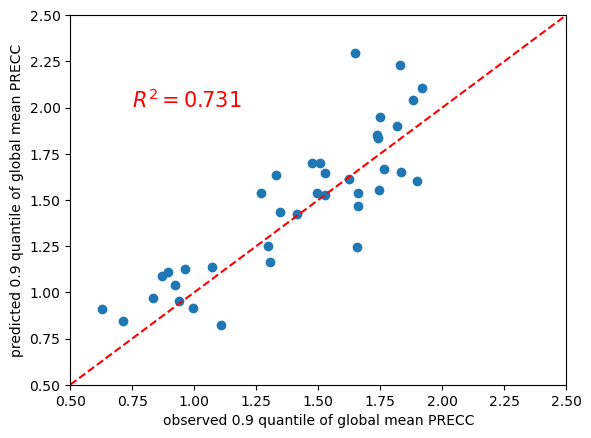

In [78]:
plt.scatter(np.quantile(glob_mean_precc['PRECC'].values[test_indx], 0.9, axis=1),
            (test_out.numpy().reshape(39)))
plt.xlim([0.5, 2.5])
plt.ylim([0.5, 2.5])
plt.xlabel('observed 0.9 quantile of global mean PRECC')
plt.ylabel('predicted 0.9 quantile of global mean PRECC')
plt.text(x=0.75,  y=2, s='$R^2 = 0.731$', color='red', size=15)
plt.axline(xy1=(0,0),slope=1, linestyle='--', color='red')
#plt.savefig('glob_nn_pred_vs_test.png')